# Tutorial

Welcome to the Phylo2Vec demo! Here, we will quickly visit the main functions of [phylo2vec](https://phylo2vec.readthedocs.io), including:
* A primer on computational phylogenetics, running popular software such as [rapidNJ](https://github.com/somme89/rapidNJ) and [IQ-TREE](https://github.com/iqtree/iqtree3) for inferring trees from molecular sequences
* Visualising trees using [ete3](https://etetoolkit.org/) or [Biopython](https://biopython.org/)
* Using basic phylo2vec functions: sam trees, converting trees to the phylo2vec format, performing operations on trees
* Using modern tools and infrastructure present in the phylo2vec package: [pixi](https://pixi.sh/), [pytest](https://docs.pytest.org/en/stable/), and [pytest-benchmark](google.com/search?q=pytest+benchmark&udm=14)

In [1]:
# Constants



data_dir = "../data"
tree_dir = "../trees"

## What is phylo2vec?

phylo2vec is a library for encoding and manipulating binary (phylogenetic) trees under a compact vector format. In its current version, the library is useful for:
* Sampling random trees
* Fast comparison of trees
* Compressing trees or files with many trees

The current version of Phylo2Vec (1.x) relies on a core written in [Rust](https://www.rust-lang.org), with bindings to Python and R. That means that you do not need to know Rust to use the package, Python or R are sufficient! To become more familiar with Rust, we recommend this [interactive book](https://rust-book.cs.brown.edu/experiment-intro.html).

Before we get started, we will quickly introduce [pixi](https://pixi.sh/), the package manger we use to orchestrate dependencies in this workshop (and in the phylo2vec package).

## A minimal pixi cheatsheet

Pixi is a past package manager built on top of the **conda** ecosystem. By default, it resolves packages from **conda-forge**, a community-driven channel with the most complete, up-to-date collection of scientific and data packages.

For the workshop (19.09.2025), installations are done for you via GitHub codespaces! However, if you want to run this notebook independently, you may either:
* Install the dependencies separately (not recommended)
* Use pixi to manage everything in a reproducible and isolated way

We will here briefly go through pixi basics: installing it, creating a pixi.toml, managing dependencies, and running scripts

### Installing pixi
```bash
curl -fsSL https://pixi.sh/install.sh | bash
```

### Creating a new project
```bash
pixi init
````

### Adding dependencies
```bash
pixi add numpy pandas matplotlib
pixi remove matplotlib
pixi add bioconda::rapidnj # Channel specification for conda packages
pixi add r-ggplot2 # Adding an R package
```

### Setting up a pixi.toml for a project
Here is a minimal file to create a custom project

```toml
[project]
name = "pixi-workshop"
version = "0.1.0"
description = "Minimal pixi project for the 19.09.2025 workshop"
channels = ["conda-forge", "bioconda", "r"]

[dependencies]
python = ">=3.11,<3.13"
numpy = "*"
pandas = "*"
bioconda::rapidnj = "*"
r-ggplot2 = "*"
```

### Running scripts
Define scripts in your pixi.toml, e.g.:
```toml
[scripts]
start = "python main.py"
notebook = "jupyter lab"
```

and run them with:
```bash
pixi run start
pixi run notebook
```

You may also run executables via `pixi run`, e.g., `pixi run rapidnj`

### Activating an environment
If you want a shell with all dependencies available:
```bash
pixi shell
```

## A short primer on phylogenetics

The overarching goal of phylogenetics is to study the evolutionary history between different entities (e.g., animal species, viral strains, languages...) using observable data. 

The main artefact of phylogenetics is a *phylogenetic tree*, a diagram which describe the evolutionary relationships between the entities of interest. A phylogenetic tree shares many similarities with the notion of trees defined in graph theory/computer science:
* It connects **vertices** (or **nodes**) with **edges** (or **branches**). 
* It is acyclic
* Any two nodes in a tree are connected by a unique path.
* Terminal nodes, or **leaves** correspond to observable species (with observable data)
* Internal nodes, or **ancestral nodes** correspond to unobserved species. They are inferred using *inference algorithms*
* **Edges**, or **branches** connect nodes and may have variable lengths (**branch lengths**). In phylogenetics, branch lengths may represent time, or the amount of evolution between a parent node and its child.

In the tree below, different species of coronaviruses are mapped, highlighting the different *genera* (*Sarbecovirus*, *Hibecovirus*, *Embecovirus*, etc.). Tree tips correspond to different viral strains, and internal nodes correspond to **unobserved** ancestors, inferred from the data at hand. 

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41579-020-00459-7/MediaObjects/41579_2020_459_Fig2_HTML.png" alt="coronavirus_tree" width="400"/>

Source: https://www.nature.com/articles/s41579-020-00459-7

Most modern phylogenetic analyses rely on molecular data, as it provides a precise and objective measure of evolutionary relationships. Thus phylogeneticists compare DNA, RNA, or protein sequences across entities (or taxa, in biology) to infer common ancestry and divergence times.

A simple genetic analysis requires at least three steps:
1. Collecting sequences
2. Aligning sequences
3. Inferring a phylogenetic tree

Sequence alignment is necessary to compare homologous positions in sequences as genes, and genomes more generally, vary in length. 

* Within a gene, some entities might present length-altering mutations such as insertions or deletions, or other structural changes. 
* Across genomes, different organisms may not have the same set of genes, making alignment essential for comparing homologous regions.

For the purpose of this tutorial, we will start with pre-aligned sequences. If interested, see chapter 3 of the book <https://decodinggenomes.org>, available for free online. Tools include [MAFFT](https://mafft.cbrc.jp/alignment/software/), [Clustal Omega](https://www.ebi.ac.uk/jdispatcher/msa/clustalo?stype=protein), [FAMSA](https://github.com/refresh-bio/FAMSA).

Phylogenetic inference is the task of inferring plausible phylogenetic trees from a molecular sequence alignment (MSA). Several approaches exist:
* The simplest is to use distance-based methods, such as **neighbor-joining**. 
    * Example tool: [rapidNJ](https://github.com/somme89/rapidNJ)
* A state-of-the-art method is **maximum likelihood**, which evaluates how well different trees explain the observed data under a chosen model of sequence evolution. 
    * Example tools: [IQ-TREE](https://github.com/iqtree/iqtree3), [RAxML-NG](https://github.com/amkozlov/raxml-ng)
* **Bayesian inference** goes further by estimating the probability distribution of trees, incorporating prior information and quantifying uncertainty.     
    * Example tool: [BEAST](https://github.com/beast-dev/beast-mcmc).

### Processing genetic sequences in Python

A useful library for manipulating genetic sequence sets in Python is [Biopython](https://biopython.org/). We will quickly visualise the first dataset of the workshop, which comprises mitochondrial DNA from (mostly) primates. The sequence is in the FASTA format, whose basic structure looks like this:
```text
>species1
atcgatcgatcg
>species2
tacgtacgtacg
>spescies3
atgcatggatgg
```

(nucleotides or amino acids may also be uppercase)

In [2]:
from Bio import AlignIO, SeqIO
from collections import Counter

import pandas as pd

def summary(file, format="fasta"):
    aln = AlignIO.read(file, format)

    n_seq = len(aln)
    aln_length = aln.get_alignment_length()

    # Count gaps per column
    gap_fractions = []
    all_counts = []
    conserved_cols = 0
    for i in range(aln_length):
        col = aln[:, i]
        counts = Counter(col)
        _, count = counts.most_common(1)[0]
        if count == n_seq:  # fully conserved
            conserved_cols += 1
        gap_fractions.append(counts.get("-", 0))
        all_counts.append(counts)

    nucleotide_counts = pd.DataFrame(all_counts).fillna(0).astype(int).sum(0).to_dict()

    return {
        "n_sequences": n_seq,
        "alignment_length": aln_length,
        "percent_conserved_sites": conserved_cols / aln_length * 100,
        "percent_gap": sum(gap_fractions) / (n_seq * aln_length) * 100,
        "nucleotide_counts": nucleotide_counts,
    }

summary("../data/primates.fa")

{'n_sequences': 14,
 'alignment_length': 232,
 'percent_conserved_sites': 5.172413793103448,
 'percent_gap': 0.03078817733990148,
 'nucleotide_counts': {'a': 1217, 'c': 1304, 't': 599, 'g': 127, '-': 1}}

### Neighbor-joining with rapidNJ

Under the neighbour joining framework, we build a tree by iteratively joining pairs of taxa with the smallest evolutionary distance. 

[rapidNJ](https://github.com/somme89/rapidNJ) is an example tool for very fast neighbour joining. Using `pixi` we run `pixi run rapidnj` to run the tool:

In [3]:
!pixi run rapidnj -h

Rapid neighbour-joining. An implementation of the canonical neighbour-joining method which utilize a fast search heuristic to reduce the running time. RapidNJ can be used to reconstruct large trees using a very small amount of memory by utilizing the HDD as storage.

USAGE: rapidnj INPUT [OPTIONS]
The INPUT can be a distance matrix in phylip (.phylip) format or a multiple alignment in stockholm (.sth) or phylip format (.phylip).
OPTIONS:
  -h, --help                display this help message and exit.
  -v, --verbose             turn on verbose output.
  -i, --input-format ARG    Specifies the type of input. pd = distance
                            matrix in phylip format, sth = multiple alignment in (single line) stockholm format.
                            fa = multiple alignment in (single line) FASTA format.
  -o, --output-format ARG   Specifies the type of output. t = phylogenetic tree in newick format
                            (default), m = distance matrix.
  -a, --evolution-

To get a tree (the default option), we can run:

In [4]:
primate_rapidnj_file = f"{tree_dir}/primates.rapidnj"
!pixi run rapidnj -v $data_dir/primates.fa -x $primate_rapidnj_file

RapidNJ v. 2.2.2ating environment                                                        
64 bit system detected.
Using 4 core(s) for distance estimation
Input format determined as FASTA
Reading data...
Input type determined as DNA.
Number of sequences: 14
Sequence length: 232
Matrix size: 14
15996 MB of memory is available
Using RapidNJ 
Using 0.000747681 MB for distance matrix
Using 0.00149536 MB for sortedMatrix
Total memory consumption is 0.00224304 MB
Computing distance matrix... 
Fastdist is enabled
Using Kimura algorithm to calculate distances
Computing phylogetic tree... 
100.00% 


We get here an output in the so-called [Newick](https://en.wikipedia.org/wiki/Newick_format) format.

This format represents taxa using nested parentheses, for example: ((Taxon1:BranchLength1, Taxon2:BranchLength2):BranchLength3);.  Subtrees are enclosed recursively in parentheses, and every tree ends with a semicolon (;).

Although not immediately easy to read, we can observe that:
* &#x2705; Great apes (Humans, Chimpanzees, Gorillas, Orangutans) form a separate clade, as expected. 
* Macaques branch off later (Rhesus Macaque, Japanese Macaque, Crab-eating Macaque).
* &#x274C; Bovine appears as the most basal lineage relative to this primate set, which does not reflect the accepted mammalian phylogeny
* &#x274C; The placement of the Squirrel Monkey deep within the tree is also unusual.

### Maximum likelihood with IQ-TREE

Under the maximum likelihood framework, we build a tree by finding the topology and branch lengths that maximize the probability of observing the given sequence alignment under a specified model of sequence evolution. The optimal tree is identified by exploring possible tree topologies using many [tree rearrangements](https://www.mun.ca/biology/scarr/Tree_Pruning_methods.html) and selecting the one with the highest likelihood score.

[IQ-TREE](https://github.com/iqtree/iqtree3) is an example tool for fast maximum likelihood estimation. For a detailed tutorial on IQ-TREE see [this tutorial](https://iqtree.github.io/workshop/molevol2023). Using `pixi` we run `pixi run iqtree` to run the tool:

In [5]:
!pixi run iqtree -h | head -n 50

IQ-TREE version 3.0.1 for Linux x86 64-bit built Jul  9 2025                             
Developed by Bui Quang Minh, Thomas Wong, Nhan Ly-Trong, Huaiyan Ren
Contributed by Lam-Tung Nguyen, Dominik Schrempf, Chris Bielow,
Olga Chernomor, Michael Woodhams, Diep Thi Hoang, Heiko Schmidt

Usage: iqtree [-s ALIGNMENT] [-p PARTITION] [-m MODEL] [-t TREE] ...

GENERAL OPTIONS:
  -h, --help           Print (more) help usages
  -s FILE[,...,FILE]   PHYLIP/FASTA/NEXUS/CLUSTAL/MSF alignment file(s)
  -s DIR               Directory of alignment files
  --seqtype STRING     BIN, DNA, AA, NT2AA, CODON, MORPH (default: auto-detect)
  -t FILE|PARS|RAND    Starting tree (default: 99 parsimony and BIONJ)
  -o TAX[,...,TAX]     Outgroup taxon (list) for writing .treefile
  --prefix STRING      Prefix for all output files (default: aln/partition)
  --seed NUM           Random seed number, normally used for debugging purpose
  --safe               Safe likelihood kernel to avoid numerical underflow
  --m

In [6]:
primate_iqtree_prefix = f"{tree_dir}/primates"
!pixi run iqtree -s $data_dir/primates.fa -m GTR+G --prefix $primate_iqtree_prefix --redo
primate_iqtree_file = f"{primate_iqtree_prefix}.treefile"

IQ-TREE version 3.0.1 for Linux x86 64-bit built Jul  9 2025                             
Developed by Bui Quang Minh, Thomas Wong, Nhan Ly-Trong, Huaiyan Ren
Contributed by Lam-Tung Nguyen, Dominik Schrempf, Chris Bielow,
Olga Chernomor, Michael Woodhams, Diep Thi Hoang, Heiko Schmidt

Host:    codespaces-a75d16 (AVX2, FMA3, 15 GB RAM)
Command: /workspaces/phylo2vec-workshop/.pixi/envs/default/bin/iqtree -s ../data/primates.fa -m GTR+G --prefix ../trees/primates --redo
Seed:    254513 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Tue Sep 16 21:41:00 2025
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file ../data/primates.fa ... Fasta format detected
Reading fasta file: done in 7.9869e-05 secs using 72.62% CPU
Alignment most likely contains DNA/RNA sequences
Constructing alignment: d

In [7]:
!cat $tree_dir/primates.treefile

(Mouse:8.3560490579,((Bovine:2.5963872339,Lemur:4.8261981617):1.1364082316,Tarsier:5.3615931116):0.8929613977,(SquirMonk:2.9419033743,((JpnMacaq:0.0000022159,(RhesusMac:0.0964670212,(CrabEMac:0.1339728562,BarbMacaq:0.5369976250):0.1170793922):0.0205802779):1.4487955312,(Gibbon:1.3183511202,(Orang:0.8632207952,(Gorilla:0.1681820186,(Chimp:0.2545515524,Human:0.1205087466):0.2193635791):0.2118152634):0.4130048706):1.0934560678):0.9378962832):1.8281724040);


This tree seems already more plausible:

* &#x2705; Mouse is the outgroup, far outside the other mammals, which makes sense given its divergence.
* &#x2705; Squirrel Monkey separates next, rather than clustering with other New World monkeys 
* &#x2705; Old World monkeys (Japanese Macaque, Rhesus Macaque, Crab-eating Macaque, Barbary Macaque) form a nested clade
* &#x2705; Apes (Gibbon, Orangutan, Gorilla, Chimpanzee, Human) form a well-supported, nested clade
* Bovine and Lemur form a clade that branches off early: unusual (bovines are not primates)
* Tarsier is slightly more derived than the Bovine–Lemur clade, which is also somewhat unexpected.

Factors that could enhance the accuracy of the tree include the choice of evolutionary model and, most importantly, the quality of the data. Here, our dataset is minuscule (232 base pairs!), so more data, for example by including more genes, would greatly improve our ability to reconstruct a plausible evolutionary history.

## Visualizing trees

Several libraries in python already exist to visualize trees. A popular library is [ete](https://etetoolkit.org/).

To have an ASCII drawing of the tree (without branch lengths represented), simply use `print`

In [8]:
# import PyQt5
from ete3 import Tree

# Load a tree from a Newick file*
primate_iqtree_tree = Tree(primate_iqtree_file)

# Print the tree in ASCII format
print(primate_iqtree_tree)


   /-Mouse
  |
  |      /-Bovine
  |   /-|
  |--|   \-Lemur
--|  |
  |   \-Tarsier
  |
  |   /-SquirMonk
  |  |
  |  |      /-JpnMacaq
   \-|   /-|
     |  |  |   /-RhesusMac
     |  |   \-|
     |  |     |   /-CrabEMac
      \-|      \-|
        |         \-BarbMacaq
        |
        |   /-Gibbon
         \-|
           |   /-Orang
            \-|
              |   /-Gorilla
               \-|
                 |   /-Chimp
                  \-|
                     \-Human


Interactive visualisations are also possible using `primate_iqtree_tree.show()`. They require PyQt5 (`pixi add --pypi PyQt5`) and may crash your notebook.

We provide here a small function to plot a tree from an ete3 Tree in matplotlib.

In [9]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection


def plot_tree(
    tree,
    align_names=False,
    name_offset=None,
    fontsize=9,
    cdict=None,
    outgroup=None,
    ax=None,
):
    """
    Plots a ete3.Tree object using matploltib.

    Adapted from: https://gist.github.com/jolespin/5d90deff552138d73de7ed4bdd9ac57a

    Parameters
    ----------
    tree : str
        An ete3.Tree object
    align_names: bool
        If True names will be aligned vertically, by default False
    name_offset : float, optional
        Offset relative to tips to write leaf_names. In BL scale, by default None
    fontsize : int, optional
        Text font size, by default 9
    ax : matplotlib.Axes object, optional
        Object on which the tree will be plotted, by default None

    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib axis containing the drawn tree
    """
    if outgroup is not None:
        if isinstance(outgroup, list):
            outgroup = tree.get_common_ancestor(outgroup)
        tree.set_outgroup(outgroup)

    if ax is None:
        ax = plt.gca()

    aligned_lines = []

    max_x = max(n.get_distance(tree) for n in tree.iter_leaves())

    if name_offset is None:
        name_offset = max_x / 50.0

    node_pos = {n2: i for i, n2 in enumerate(tree.get_leaves()[::-1])}
    node_list = itertools.chain(tree.iter_descendants(strategy="postorder"), [tree])

    # draw tree
    for node in node_list:
        # Parent style
        # pstyle = node.img_style

        x = sum(n2.dist for n2 in node.iter_ancestors()) + node.dist

        if node.is_leaf():
            y = node_pos[node]
            if align_names:
                x = max_x
                aligned_lines.append(((x, y), (max_x + name_offset, y)))

        else:
            y = np.mean([node_pos[n2] for n2 in node.children])
            node_pos[node] = y

            # draw vertical line
            ax.plot(
                [x, x],
                [node_pos[node.children[0]], node_pos[node.children[-1]]],
                c="k",
            )

            # draw horizontal lines
            for child in node.children:
                # Child style
                # cstyle = child.img_style
                ax.plot(
                    [x, x + child.dist],
                    [node_pos[child], node_pos[child]],
                    c="k",
                )

        # Node label
        ax.text(
            x + name_offset,
            y,
            node.name,
            va="center",
            size=fontsize,
            c="k",
        )

        # Node point
        ax.scatter(
            x,
            y,
            c=(cdict.get(node.name, "none") if cdict else "k"),
            zorder=10,
        )

    ali_line_col = LineCollection(aligned_lines, colors="k")

    ax.add_collection(ali_line_col)

    # ax.set_axis_off()
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=fontsize)

    return ax

The x-axis consitute the branch lengths

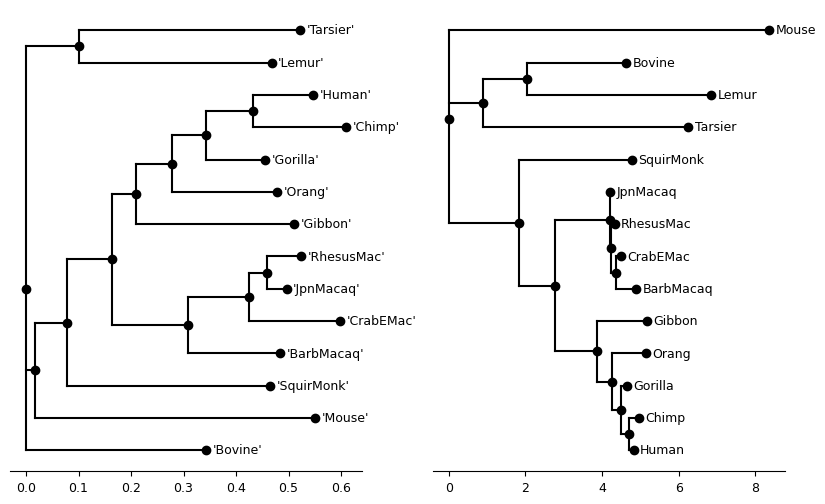

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
primate_rapidnj_tree = Tree(primate_rapidnj_file)
plot_tree(primate_rapidnj_tree, ax=axs[0])
plot_tree(primate_iqtree_tree, ax=axs[1])
plt.show()

## Manipulating trees with phylo2vec

Before looking at how to use the produced trees with phylo2vec, we will quickly visit its main functions.

To import phylo2vec, simply run `import phylo2vec`

In [11]:
import phylo2vec as p2v

### Sampling a random tree
The definition of phylo2vec makes it very convenient to rapidly sample large, or lots of, trees.

Use `sample_vector` to sample a random tree topology. 

In [12]:
p2v.sample_vector?

Signature: p2v.sample_vector(n_leaves: int, ordered: bool = False) -> numpy.ndarray
Docstring:
Sample a random tree via Phylo2Vec, in vector form.

Parameters
----------
n_leaves : int
    Number of leaves (>= 2)
ordered : bool, optional
    If True, sample an ordered tree, by default False

    True:
    v_i in {0, 1, ..., i} for i in (0, n_leaves-1)

    False:
    v_i in {0, 1, ..., 2*i} for i in (0, n_leaves-1)

Returns
-------
numpy.ndarray
    Phylo2Vec vector
File:      /workspaces/phylo2vec-workshop/.pixi/envs/default/lib/python3.11/site-packages/phylo2vec/utils/vector.py
Type:      function

In [13]:
v5 = p2v.sample_vector(5)
v5

array([0, 2, 2, 6])

Use `sample_matrix` to sample a random tree (topology + branch lengths)

In [14]:
p2v.sample_matrix?

Signature: p2v.sample_matrix(n_leaves: int, ordered: bool = False) -> numpy.ndarray
Docstring:
Sample a random tree with branch lengths via Phylo2Vec, in matrix form.

Parameters
----------
n_leaves : int
    Number of leaves (>= 2)
ordered : bool, optional
    If True, sample an ordered tree, by default False

Returns
-------
numpy.ndarray
    Phylo2Vec matrix
    Dimensions (n_leaves, 3)
    1st column: Phylo2Vec vector
    2nd and 3rd columns: branch lengths of cherry [i] in the ancestry matrix
File:      /workspaces/phylo2vec-workshop/.pixi/envs/default/lib/python3.11/site-packages/phylo2vec/utils/matrix.py
Type:      function

In [15]:
m6 = p2v.sample_matrix(6).round(3)
m6

array([[0.   , 0.384, 0.843],
       [2.   , 0.158, 0.59 ],
       [1.   , 0.952, 0.08 ],
       [0.   , 0.067, 0.585],
       [6.   , 0.056, 0.361]])

### Conversion: v <--> Newick

Use `to_newick` to convert a vector to a Newick string.

In [16]:
newick5 = p2v.to_newick(v5)
newick6 = p2v.to_newick(m6)

print(f"Newick from v5: {newick5}")
print(f"Newick from m6: {newick6}")

Newick from v5: (((0,1)6,(2,3)5)7,4)8;
Newick from m6: (((0:0.384,4:0.843)6:0.067,((1:0.158,3:0.59)7:0.952,5:0.08)8:0.585)9:0.056,2:0.361)10;


Use `from_newick` to convert a Newick string to a vector.

In [17]:
v5_new = p2v.from_newick(newick5)
print(f"Is v5 equal to v5_new? {np.array_equal(v5, v5_new)}")

m6_new = p2v.from_newick(newick6)
print(f"Is m6 equal to m6_new? {np.array_equal(m6, m6_new)}")

Is v5 equal to v5_new? True
Is m6 equal to m6_new? True


### Conversion: v <--> Edge list

An intuitive way to represent a tree topology (or any graph) is a list of edges


In [18]:
p2v.to_edges?

Signature: p2v.to_edges(v: numpy.ndarray) -> List[Tuple[int, int]]
Docstring:
Convert a Phylo2Vec vector to an edge list

Each edge is represented as a list of two nodes (child, parent)

Parameters
----------
v : numpy.ndarray
    Phylo2Vec vector

Returns
-------
edges : List[Tuple[int, int]]
    List of (child, parent) edges
File:      /workspaces/phylo2vec-workshop/.pixi/envs/default/lib/python3.11/site-packages/phylo2vec/base/edges.py
Type:      function

Use `to_edges` to convert a vector to a list of tree edges (node1, node2)
Use `from_edges` to convert a list of edges back to a vector

In [19]:
edges5 = p2v.to_edges(v5)
print(edges5)
v5_edges = p2v.from_edges(edges5)
print(f"Is v5 equal to v5_edges? {np.array_equal(v5, v5_edges)}")

[(2, 5), (3, 5), (0, 6), (1, 6), (6, 7), (5, 7), (7, 8), (4, 8)]
Is v5 equal to v5_edges? True


### Conversion: v <--> Ancestry matrix

An intermediate way between the compact phylo2vec format and the Newick string of representing tree topology is what we call the "ancestry" matrix, a matrix of triplets [child1, child2, parent].

Use `to_ancestry` to convert a vector to an ancestry matrix

In [20]:
anc5 = p2v.to_ancestry(v5)
anc6 = p2v.to_ancestry(m6[:, 0].astype(int))

print(f"Ancestry from v5:\n{anc5}")
print(f"Ancestry from m6:\n{anc6}")

Ancestry from v5:
[[2 3 5]
 [0 1 6]
 [6 5 7]
 [7 4 8]]
Ancestry from m6:
[[ 0  4  6]
 [ 1  3  7]
 [ 7  5  8]
 [ 6  8  9]
 [ 9  2 10]]


The ancestry matrix is also useful to understand the order of the branch lengths in the matrix format. For a row $i$ of m6, the branch lengths are those of the children of triplet $i$.

<Axes: >

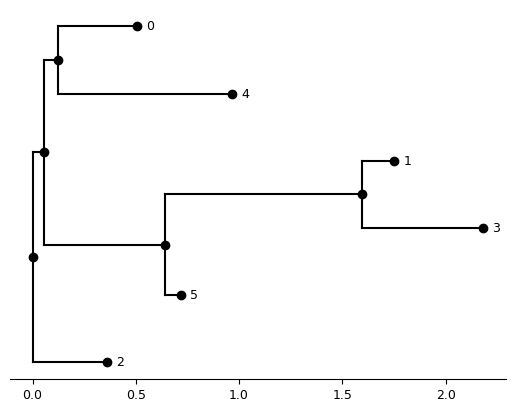

In [21]:
plot_tree(Tree(newick6))

### Back to our primate trees
phylo2vec works on *rooted* integer trees, while both rapidNJ and IQ-TREE produce *unrooted* trees. Before loading the produced trees into phylo2vec, we need to:
1. Root the trees (we will here use `Mouse`, as we assume that it is the most distantly related taxon). For that, we use the `set_outgroup` function of ete3
2. Apply a mapping of string to integer to keep the same information while having an integer tree. For that, we use the `create_label_mapping` function of phylo2vec

In [22]:
from phylo2vec.utils.newick import create_label_mapping

def load_tree(file, root=None, with_branch_lengths=True):
    # Load into ete3 for potential re-rooting
    tr = Tree(file)
    # Reroot
    if root:
        tr.set_outgroup(root)
    # Write the tree back to Newick
    if with_branch_lengths:
        newick_str = tr.write(format=1, dist_formatter="%.06f")
    else:
        newick_str = tr.write(format=9)

    # Apply a mapping
    newick_int, label_mapping = create_label_mapping(newick_str.replace("'", ""))

    data = {
        "newick_str": newick_str,
        "newick_int": newick_int,
        "label_mapping": dict(sorted(label_mapping.items())),
    }

    # Convert to phylo2vec object
    p2v_obj = p2v.from_newick(newick_int)

    if p2v_obj.ndim == 1:
        # ndim == 1 means it's a vector
        data["v"] = p2v_obj
    elif p2v_obj.ndim == 2:
        # ndim == 2 means it's a matrix
        data["m"] = p2v_obj
        data["v"] = p2v_obj[:, 0].astype(int)
    else:
        raise ValueError("Unexpected ndim in phylo2vec object")
    return data

In [23]:
primate_iqtree_data = load_tree(primate_iqtree_file, root="Mouse", with_branch_lengths=False)

primate_iqtree_data

{'newick_str': '(Mouse,(((Bovine,Lemur),Tarsier),(SquirMonk,((JpnMacaq,(RhesusMac,(CrabEMac,BarbMacaq))),(Gibbon,(Orang,(Gorilla,(Chimp,Human))))))));',
 'newick_int': '(0,(((1,2),3),(4,((5,(6,(7,8))),(9,(10,(11,(12,13))))))));',
 'label_mapping': {0: 'Mouse',
  1: 'Bovine',
  2: 'Lemur',
  3: 'Tarsier',
  4: 'SquirMonk',
  5: 'JpnMacaq',
  6: 'RhesusMac',
  7: 'CrabEMac',
  8: 'BarbMacaq',
  9: 'Gibbon',
  10: 'Orang',
  11: 'Gorilla',
  12: 'Chimp',
  13: 'Human'},
 'v': array([ 0,  1,  3,  5,  4,  5,  6,  7, 11,  9, 10, 11, 12])}

Here:
* `newick_str` is the orginal tree (without branch lengths)
* `newick_int` is the same tree, but with using integers to represent leaves
* `label_mapping` is a dict of the integer-to-taxon mapping
* `v` is the phylo2vec vector extracted from `newick_int`

<Axes: >

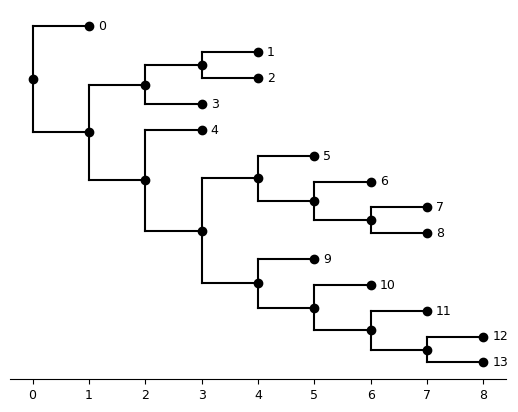

In [24]:
plot_tree(Tree(primate_iqtree_data["newick_int"]))

One of the core functions of phylo2vec is to convert several objects representing trees to this compact vector format, and vice versa.

In [25]:
import phylo2vec as p2v

v = primate_iqtree_data["v"]
print(f"Vector representation: {repr(v)}")
print(f"Original integer Newick: {primate_iqtree_data['newick_int']}")
print(f"Converted integer Newick: {p2v.to_newick(v)}")

Vector representation: array([ 0,  1,  3,  5,  4,  5,  6,  7, 11,  9, 10, 11, 12])
Original integer Newick: (0,(((1,2),3),(4,((5,(6,(7,8))),(9,(10,(11,(12,13))))))));
Converted integer Newick: (0,(((1,2)23,3)24,(4,((5,(6,(7,8)18)19)20,(9,(10,(11,(12,13)14)15)16)17)21)22)25)26;


Another example is a list of graph edges of the form (child, parent)

In [26]:
edges = p2v.to_edges(v)
print(f"Edge list: {edges}")
new_v = p2v.from_edges(edges)
assert np.array_equal(v, new_v)

Edge list: [(12, 14), (13, 14), (11, 15), (14, 15), (10, 16), (15, 16), (9, 17), (16, 17), (7, 18), (8, 18), (6, 19), (18, 19), (5, 20), (19, 20), (20, 21), (17, 21), (4, 22), (21, 22), (1, 23), (2, 23), (23, 24), (3, 24), (24, 25), (22, 25), (0, 26), (25, 26)]


In [27]:
primate_rapidnj_data = load_tree(primate_rapidnj_file, root="'Mouse'")

primate_rapidnj_data

{'newick_str': "('Mouse':0.267050,((((((('Human':0.115680,'Chimp':0.178270):0.088192,'Gorilla':0.112280):0.066043,'Orang':0.201080):0.068184,'Gibbon':0.301130):0.045591,((('RhesusMac':0.066186,'JpnMacaq':0.038473):0.032833,'CrabEMac':0.172450):0.116060,'BarbMacaq':0.174200):0.145580):0.085270,'SquirMonk':0.386660):0.061420,(('Tarsier':0.420990,'Lemur':0.367210):0.101000,'Bovine':0.343560):0.017041):0.267050);",
 'newick_int': '(0:0.267050,(((((((1:0.115680,2:0.178270):0.088192,3:0.112280):0.066043,4:0.201080):0.068184,5:0.301130):0.045591,(((6:0.066186,7:0.038473):0.032833,8:0.172450):0.116060,9:0.174200):0.145580):0.085270,10:0.386660):0.061420,((11:0.420990,12:0.367210):0.101000,13:0.343560):0.017041):0.267050);',
 'label_mapping': {0: 'Mouse',
  1: 'Human',
  2: 'Chimp',
  3: 'Gorilla',
  4: 'Orang',
  5: 'Gibbon',
  6: 'RhesusMac',
  7: 'JpnMacaq',
  8: 'CrabEMac',
  9: 'BarbMacaq',
  10: 'SquirMonk',
  11: 'Tarsier',
  12: 'Lemur',
  13: 'Bovine'},
 'm': array([[0.0000e+00, 4.2099

### Advantages of phylo2vec package

#### Sampling speed

Example of a simple benchmark against ete3 and IQ-TREE.

We use `timeit` for a simple benchmark of python commands.

We use `time` inside of pixi to minimise overhead when calling `iqtree`. We use the `quiet` option to limit print messages. Note that this benchmark is an upper bound of the actual time due to I/O operations.

In [28]:
big_n = 10000
# Sample a topology
%timeit p2v.sample_vector(big_n)
%timeit tr = Tree(); tr.populate(big_n)
# Sample a topology with branch lengths
%timeit p2v.sample_matrix(big_n)
!pixi run -- time iqtree -ru 10000 10000.tree -redo --quiet

641 μs ± 36.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
29.4 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
674 μs ± 17 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
time: command not foundnvironment                                                        

Available tasks:
	build
	delete-release
	download-latest-data
	publish
	release
	set-default-repo
	setup-data
	start
	unzip
	update-release-data
	zip                                                                            

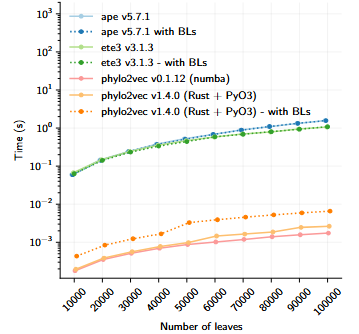

Sampling speed of phylo2vec and other libraries. Author: Neil Scheidwasser. Source: *Pandemic preparedness in a vector*, PhD thesis (in preparation, 2025). License: CC BY 4.0.

#### Memory efficiency

Example of a memory benchmark against the Newick-formatted outputs from IQ-TREE and rapidNJ.

We use `sys.getsizeof` to evaluate the size of standard python objects, and the `nbytes` attribute to evaluate the size of NumPy array (the base for phylo2vec objects in Python).

In [29]:
import sys

print(f"Newick with branch lengths:\nNewick = {sys.getsizeof(primate_rapidnj_data['newick_str'])}, P2V = {primate_rapidnj_data['m'].nbytes}")
print(f"Newick without branch lengths:\nNewick = {sys.getsizeof(primate_iqtree_data['newick_str'])}, P2V = {primate_iqtree_data['v'].nbytes}")

Newick with branch lengths:
Newick = 445, P2V = 312
Newick without branch lengths:
Newick = 183, P2V = 104


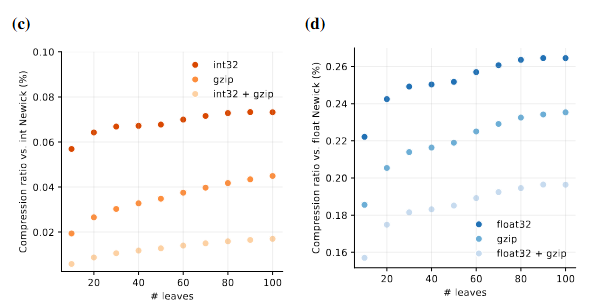

File size ratio 10,000 random tree topologies (resp. trees with branch lengths) with coronavirus taxa saved:
 * as a plain-text file (reference)
 * a hierarchical data format (HDF) file containing the trees as an array of phylo2vec vectors (resp. matrices) + and a mapping of taxon-to-integer labels
 
Author: Neil Scheidwasser. Source: *Pandemic preparedness in a vector*, PhD thesis (in preparation, 2025). License: CC BY 4.0.